In [2]:
import os,glob
import numpy as np 
import matplotlib.pyplot as plt
import cv2

import nrrd
import nibabel as nib

ModuleNotFoundError: No module named 'cv2'

# Paths


In [2]:
dataInputPath ='Volumes/'
imagePathInput =os.path.join(dataInputPath,'MRIs/')
maskPathInput =os.path.join(dataInputPath,'Masks/')


dataOutPath ='Slices/'
imagePathOutput =os.path.join(dataOutPath,'MRIs/')
maskPathOutput =os.path.join(dataOutPath,'Masks/')

# Opening Files

### Constants


In [3]:
HOUNSFIELD_MAX = 1300
HOUNSFIELD_MIN = 0
HOUNSFIELD_RANGE = HOUNSFIELD_MAX-HOUNSFIELD_MIN

SLICE_X =False
SLICE_Y =False
SLICE_Z =True

SLICE_DECIMATE_IDENTIFIER =3

## Opening MRI

In [4]:

img = nib.load('brain.nii').get_fdata()
np.min(img),np.max(img),img.shape,type(img)

(0.0, 1393.0, (256, 256, 25), numpy.memmap)

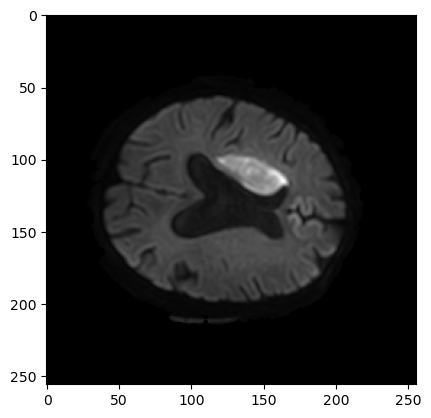

In [5]:
imgSlice=img[:,:,15]
plt.imshow(imgSlice,cmap='gray')
plt.show()

## Opening Mask

### nii file

In [6]:
mask = nib.load('mask.nii').get_fdata()
np.min(mask),np.max(mask),mask.shape,type(mask)

(0.0, 1.0, (256, 256, 25), numpy.memmap)

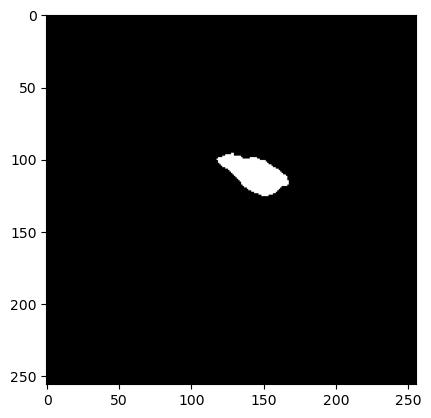

In [7]:
maskSlice=mask[:,:,15]
plt.imshow(maskSlice,cmap='gray')
plt.show()

### Using Slicerio [Particular Segment]

In [8]:
import slicerio

In [1]:
segmentation_info = slicerio.read_segmentation_info('Segmentation.seg.nrrd')
segment_names = slicerio.segment_names(segmentation_info)
print(f'Segment Names : {segment_names[0]}')
    
    # Change segment names that are not 'core' to 'core'
segment_names = ['core' if sn != 'core' else sn for sn in segment_names]
    
    # Create a dictionary mapping segment names to label values
dict_label = {sn: 1 for sn in segment_names}

dict_label

NameError: name 'slicerio' is not defined

In [10]:
def readmask(maskpath):
    segmentation_info = slicerio.read_segmentation_info(maskpath)
    voxels, header = nrrd.read(maskpath)
    segment_names = slicerio.segment_names(segmentation_info)
    print(f'Segment Names : {segment_names}')
    
    extracted_voxels, extracted_header = slicerio.extract_segments(
    voxels, header, segmentation_info, [(segment_names[0], 1)])
    return extracted_voxels

In [11]:
maskk = readmask('Segmentation.seg.nrrd')
np.min(maskk),np.max(maskk),maskk.shape,type(maskk)

Segment Names : ['CORE', 'BACKGROUND']


(0.0, 1.0, (256, 256, 25), numpy.ndarray)

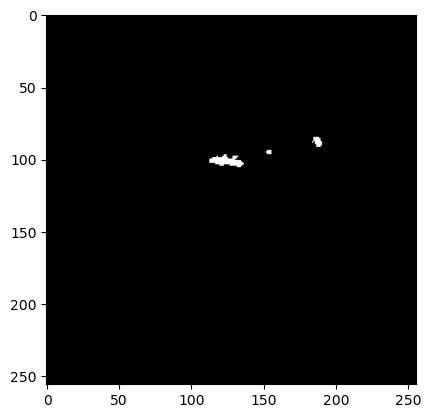

In [12]:
maskkSlice=maskk[:,:,15]
plt.imshow(maskkSlice,cmap='gray')
plt.show()

In [13]:
comparison = mask == maskk

# Get the sum of True and False values
true_sum = np.sum(comparison)
false_sum = np.sum(~comparison)  # ~comparison is the negation of the comparison (False becomes True, True becomes False)

print("Sum of True values:", true_sum)
print("Sum of False values:", false_sum)

Sum of True values: 1630146
Sum of False values: 8254


# Normalizing MRI

In [14]:
def normalizeImageIntesityRange(img):
    img[img>HOUNSFIELD_MAX]=HOUNSFIELD_MAX
    img[img<HOUNSFIELD_MIN]=HOUNSFIELD_MIN
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

nimg = normalizeImageIntesityRange(img)
np.min(nimg),np.max(nimg),nimg.shape,type(nimg)

(0.0, 1.0, (256, 256, 25), numpy.ndarray)

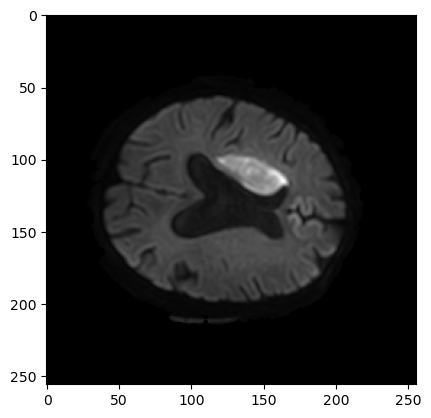

In [15]:
nimgSlice=nimg[:,:,15]
plt.imshow(nimgSlice,cmap='gray')
plt.show()

In [16]:
def readImageVolume(imgPath,normalize=True):
   img = nib.load(imgPath).get_fdata()
   if normalize:
        return normalizeImageIntesityRange(img)
   else:
       return img

# Saving Slices


In [17]:
def saveSlice(img, fname, path):
    img = np.uint8(img * 255)
    fout = os.path.join(path, f'{fname}.png')
    print(f"Slice min: {img.min()}, max: {img.max()}")  # Debugging
    cv2.imwrite(fout, img)
    print(f'[+] Slice Saved: {fout}')

In [18]:
maskk[:,:,15].max()

1.0

In [19]:
saveSlice(nimg[:,:,15],'test',imagePathOutput)
saveSlice(maskk[:,:,15],'test',maskPathOutput)

Slice min: 0, max: 223
[+] Slice Saved: Slices/MRIs/test.png
Slice min: 0, max: 255
[+] Slice Saved: Slices/Masks/test.png


## Savinng All Slices of one file


In [20]:
# Slice image in all directions and save
def sliceAndSaveVolumeImage(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    if SLICE_X:
        cnt += dimx
        print('Slicing X: ')
        for i in range(dimx):
            saveSlice(vol[i,:,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', path)
            
    if SLICE_Y:
        cnt += dimy
        print('Slicing Y: ')
        for i in range(dimy):
            saveSlice(vol[:,i,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', path)
            
    if SLICE_Z:
        cnt += dimz
        print('Slicing Z: ')
        for i in range(dimz):
            saveSlice(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)
    return cnt

In [21]:
# Read and process image volumes
for index, filename in enumerate(sorted(glob.iglob(imagePathInput+'*.nii'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'MRI'+str(index), imagePathOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

Volumes/MRIs\001_segemnted nanaware vinod_NANAWARE_VINOD_61Y_M_JD_isoReg_-_DWI_HR.nii (256, 256, 25) 537 0.0 1.0
256 256 25
Slicing Z: 
Slice min: 0, max: 88
[+] Slice Saved: Slices/MRIs/MRI0-slice000_z.png
Slice min: 0, max: 110
[+] Slice Saved: Slices/MRIs/MRI0-slice001_z.png
Slice min: 0, max: 110
[+] Slice Saved: Slices/MRIs/MRI0-slice002_z.png
Slice min: 0, max: 151
[+] Slice Saved: Slices/MRIs/MRI0-slice003_z.png
Slice min: 0, max: 146
[+] Slice Saved: Slices/MRIs/MRI0-slice004_z.png
Slice min: 0, max: 113
[+] Slice Saved: Slices/MRIs/MRI0-slice005_z.png
Slice min: 0, max: 194
[+] Slice Saved: Slices/MRIs/MRI0-slice006_z.png
Slice min: 0, max: 234
[+] Slice Saved: Slices/MRIs/MRI0-slice007_z.png
Slice min: 0, max: 185
[+] Slice Saved: Slices/MRIs/MRI0-slice008_z.png
Slice min: 0, max: 144
[+] Slice Saved: Slices/MRIs/MRI0-slice009_z.png
Slice min: 0, max: 255
[+] Slice Saved: Slices/MRIs/MRI0-slice010_z.png
Slice min: 0, max: 255
[+] Slice Saved: Slices/MRIs/MRI0-slice011_z.png
S

In [22]:
# img = nib.load('brain.nii').get_fdata()
# img = normalizeImageIntesityRange(img)
# print( img.shape, np.sum(img.shape), np.min(img), np.max(img))
# numOfSlices = sliceAndSaveVolumeImage(img, 'MRI'+str(12), 'C:/Users/Soham Sant/Desktop/UNET/test_img')
# print(f'\n {numOfSlices} slices created \n')

In [23]:
for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'*.nrrd'))):
    img = readmask(filename)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'Mask'+str(index), maskPathOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

Segment Names : ['core', 'background']
Volumes/Masks\001_segemnted nanaware vinod_Segmentation.seg.nrrd (256, 256, 25) 537 0.0 1.0
256 256 25
Slicing Z: 
Slice min: 0, max: 0
[+] Slice Saved: Slices/Masks/Mask0-slice000_z.png
Slice min: 0, max: 0
[+] Slice Saved: Slices/Masks/Mask0-slice001_z.png
Slice min: 0, max: 0
[+] Slice Saved: Slices/Masks/Mask0-slice002_z.png
Slice min: 0, max: 0
[+] Slice Saved: Slices/Masks/Mask0-slice003_z.png
Slice min: 0, max: 0
[+] Slice Saved: Slices/Masks/Mask0-slice004_z.png
Slice min: 0, max: 0
[+] Slice Saved: Slices/Masks/Mask0-slice005_z.png
Slice min: 0, max: 0
[+] Slice Saved: Slices/Masks/Mask0-slice006_z.png
Slice min: 0, max: 255
[+] Slice Saved: Slices/Masks/Mask0-slice007_z.png
Slice min: 0, max: 255
[+] Slice Saved: Slices/Masks/Mask0-slice008_z.png
Slice min: 0, max: 255
[+] Slice Saved: Slices/Masks/Mask0-slice009_z.png
Slice min: 0, max: 255
[+] Slice Saved: Slices/Masks/Mask0-slice010_z.png
Slice min: 0, max: 255
[+] Slice Saved: Slices